In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neighbors import KernelDensity 
import os 

import torch
import torch.nn as nn
from torchdiffeq import odeint
from torch.optim import Adam

torch.Size([2000, 2])


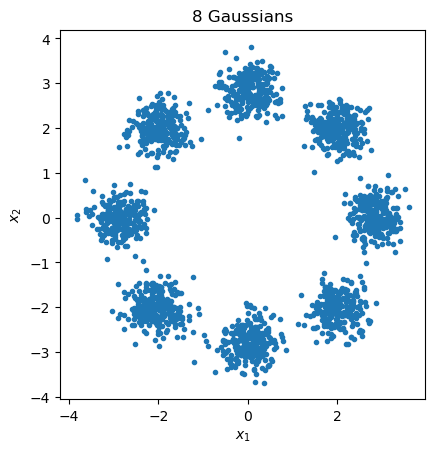

In [2]:
# generate data
n_samples = 2000
z = torch.randn(n_samples, 2)

sq = 1./np.sqrt(2)
fact = 4.*sq
mus = [fact*torch.Tensor([[1.],[0.]]), fact*torch.Tensor([[-1.],[0.]]), fact*torch.Tensor([[0.],[1.]]), fact*torch.Tensor([[0.],[-1.]]),\
    fact*torch.Tensor([[sq],[sq]]), fact*torch.Tensor([[-sq],[sq]]), fact*torch.Tensor([[sq],[-sq]]), fact*torch.Tensor([[-sq],[-sq]])]

sig = 0.1 * torch.Tensor([[1.,0.0],[0.0,1.]])
x_all = [mu + torch.linalg.cholesky(sig)@torch.randn(2,int(n_samples/8.)) for mu in mus]
x = torch.hstack(x_all).T
mus = torch.hstack(mus) # 2,8
print(x.shape)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal', 'box')
ax.scatter(x[:,0],x[:,1],marker='.'), plt.title('8 Gaussians')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [3]:
# flow matching with optimal transport
class FM(nn.Module):
    def __init__(self, size_hidden, sigma_min=1e-5):
        super().__init__()
        self.sigma_min = sigma_min

        self.W1 = nn.Linear(3, size_hidden, bias=True) # additionally condition on noise level
        self.W2 = nn.Linear(size_hidden, size_hidden, bias=True)
        self.W3 = nn.Linear(size_hidden, 2, bias=True)

    def forward(self, ipt, sigma_):
        ipt_stacked = torch.hstack((ipt, sigma_))
        tmp = torch.relu(self.W1(ipt_stacked))
        tmp = torch.relu(self.W2(tmp))
        return self.W3(tmp)

    def fit(self, x, max_iter, lr):
        optim = Adam(params=self.parameters(), lr=lr)
        self.train()
        
        losses = []
        for iter_ in range(max_iter):
            # sample time steps
            t = torch.rand(x.shape[0]).float().to(x.device)

            # add noise
            eta = torch.randn_like(x)
            sigma_t = 1 - (1-self.sigma_min)*t
            mu_t = t[:,None]*x
            xt = mu_t + sigma_t[:,None]*eta

            # conditional flow, target
            u = (x - (1-self.sigma_min)*xt)/(1-(1-self.sigma_min)*t[:,None]) # vector field u, probability eq. path 21

            # regression net, prediction
            v = self.forward(xt, t[:,None])

            loss = ((v-u)**2).mean()
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.item())
            x = shuffle(x)
        
        return losses
    
    def sample(self, n_samples, ode_steps):
        x0 = torch.randn_like(x)

        def func_conditional(t, x):
            t_curr = torch.ones(x.shape[0], device=x.device) * t
            x_ipt = (1 - (1 - self.sigma_min) * t) * x0 + t*x # conditional flow, eq (22) 
            return self.forward(x_ipt, t_curr.reshape(x.shape[0],-1))
                
        with torch.no_grad():
            traj = odeint(
                func_conditional,
                y0=x0,
                t=torch.linspace(0, 1, ode_steps, device=x.device),
                method='euler',
                atol=1e-5,
                rtol=1e-5
            )
        return traj

In [4]:
# settings
max_iter = 5000
lr = 5.0E-3
size_hidden = 128
ode_steps = 16 

In [5]:
# training
flow = FM(size_hidden=size_hidden)
loss = flow.fit(x=x,max_iter=max_iter,lr=lr)

In [6]:
# sampling
samples = flow.sample(n_samples=n_samples,ode_steps=ode_steps)

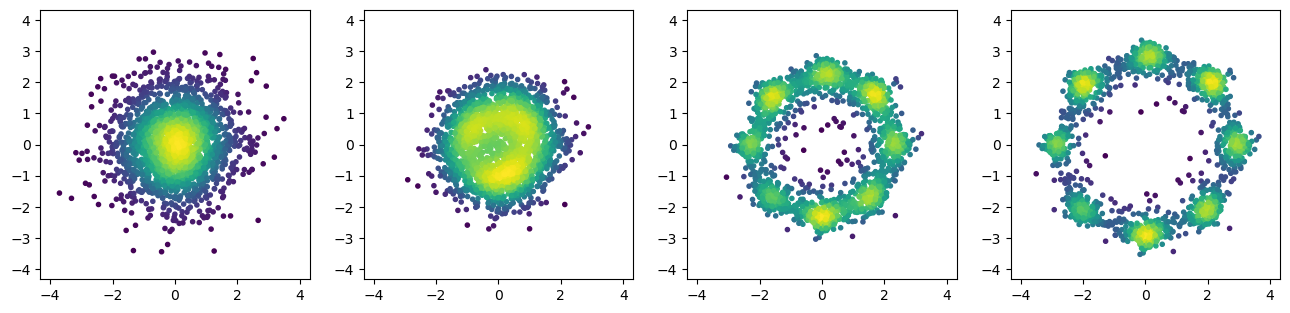

In [7]:
# make plot for different noise levels
indices = [0,7,12,15]
fig, ax = plt.subplots(1,len(indices),figsize=(4*len(indices),4),sharex=False,sharey=False)
for index_idx, index in enumerate(indices):
    samples_curr = samples[index].cpu().numpy()

    # fit KDE at current noise level
    kde = KernelDensity(bandwidth=.4).fit(samples_curr)
    xx, yy = np.meshgrid(np.linspace(x.min().item(),x.max().item(),100),np.linspace(x.min().item(),x.max().item(),100))
    x_grid = np.stack((xx.ravel(), yy.ravel()),1)
    density = np.exp(kde.score_samples(x_grid))
    samples_kde = np.exp(kde.score_samples(samples_curr))

    ax[index_idx].scatter(samples_curr[:,0], samples_curr[:,1],marker='.',c=samples_kde)
    ax[index_idx].set_aspect('equal')
    ax[index_idx].set_xlim([x.min().item()-0.5,x.max().item()+0.5]), ax[index_idx].set_ylim([x.min().item()-0.5,x.max().item()+0.5])
plt.savefig(os.getcwd() + '/out/flow_matching.png', bbox_inches='tight')
plt.show()